In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Quadratic objective with linear equality constraints
Consider the problem quadratic program with affine equality constraint
\begin{align*}
       \min_{x \in \mathbb{R}^n} \qquad&\frac{1}{2} x^TQx + c^Tx \\
       \mathrm{s.t.}\qquad& Ax = b
\end{align*}
where $Q \in \mathbb{R}^{n \times n}$ is positive definite, $c \in \mathbb{R}^{n}$, $A \in \mathbb{R}^{p \times n}$ and $B \in \mathbb{R}^{p}$. KKT optimality conditions for $x \in \mathbb{R}^n$ and $\lambda \in \mathbb{R}^p$ can be written
\begin{align*}
    Q x + c + A^T\lambda &=0\\
    Ax = b.
\end{align*}
This is equivalently written
\begin{align*}
    \begin{pmatrix}
        Q &A^T\\
        A& 0
    \end{pmatrix}
    \begin{pmatrix}
        x\\
        \lambda
    \end{pmatrix}
    =
    \begin{pmatrix}
        -c\\
        b
    \end{pmatrix}
\end{align*}
So that the solution is found by matrix inversion.
\begin{align*}
    \begin{pmatrix}
        x\\
        \lambda
    \end{pmatrix}
    =
    \begin{pmatrix}
        Q &A^T\\
        A& 0
    \end{pmatrix}^{-1}
    \begin{pmatrix}
        -c\\
        b
    \end{pmatrix}
\end{align*}

#### Solve the KKT system

Write a function `KKTquad` which takes as input $Q$, $c$, $A$ and $b$ and outputs the solution $x^*$ minimising the corresponding quadratic cost under linear constraint as well as the corresponding multipliers $\lambda^*$.


In [38]:
def KKTquad(Q,c,A,b):
    #On vérifie que Q est bien définie positive
    #Si il y a une erreur alors Q n'est pas définie positive
    np.linalg.cholesky(Q)
    
    n = Q.shape[0]
    p = A.shape[0] 
    
    #On créer la matrice np.array([[Q, A.transpose()],[A , 0]]):
    matrice = np.linalg.inv(np.vstack((np.hstack((Q, A.T)), np.hstack((A, np.zeros((p, p)))))))
    #print("M =",matrice)
    
    #on créer le vecteur (-c,b)
    vect = np.hstack((-c,b))
    #print("vect =",vect)
    
    #On effectue le calcul
    vectxl = matrice.dot(vect)
    #print("x,l=",vectxl)
    
    #On sépare le vecteur finale en deux variable x et lambda
    x = vectxl[:n]
    l = vectxl[n:]
    
    return (x,l)

#### Solve a simple quadratic problem with linear equality constraint

You will test your function with the following input data
\begin{align*}
    Q &= \begin{pmatrix}2&1\\1&2\end{pmatrix}\\
    c &= \begin{pmatrix}1\\2\end{pmatrix}\\
    A &= \begin{pmatrix} -0.1 & 1\end{pmatrix}\\
    b &= \begin{pmatrix} -0.5\end{pmatrix}\\
\end{align*}
Verify that the solution given by your function indeed satisfy KKT conditions.

This is a problem over $\mathrm{R}^2$, you will use the contour function of the previous practical sessions to illustrate the function level set, the constraints and the solution you obtain. 

In [39]:
Q=np.array([[2,1],[1,2]])
A=np.array([[-0.1,1]])
c=np.array([1,2])
b=np.array([-0.5])

x,l = KKTquad(Q,c,A,b)
print(x)
print(l)

[-0.27027027 -0.52702703]
[-0.67567568]


In [40]:
#On vérifie que cette solution verifie les conditions KKT

#1ère condition Qx + A.T * lambda = -c     (-c = (-1,-2))
print("Qx + A.T*lambda =",Q.dot(x)+A.T.dot(l))
print("-c =", -c)
print()

#2ème condition Ax = b     (b = -0.5)
print("Ax =",A.dot(x))
print("b =", b)

Qx + A.T*lambda = [-1. -2.]
-c = [-1 -2]

Ax = [-0.5]
b = [-0.5]


In [41]:
def plot_contour(a, b, c, d, Q, C, A, B, ax):
    
    delta = 0.05
    x0, x1 = np.meshgrid(np.arange(a, b, delta), np.arange(c, d, delta)) 
    plot = np.zeros(x0.shape)
    
    for i in range(x0.shape[0]):
        for j in range(x0.shape[1]):
            x=np.array([[x0[i,j]],[x1[i,j]]])
            plot[i,j] = np.dot(x.T,np.dot(Q,x))/2 + np.dot(C.T,x)
            
    ax.contour(x0, x1,plot, 50)
    xx=np.linspace(a,np.max(x0),1000)
    ax.plot(xx,(B[0]-A[0][0]*xx)/A[0][1] )

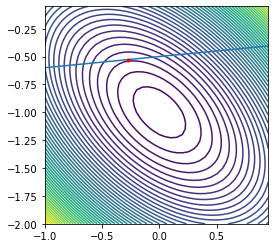

In [42]:
fig, ax = plt.subplots(figsize=(4,4))
plot_contour(-1,1,-2,0,Q,c,A,b,ax)
plt.plot(x[0],x[1],'r.');

## Sequential quadratic programing (SQP)
Consider the problem
\begin{align*}
    \min_{x \in \mathbb{R}^n} \qquad&f(x)\\
    \mathrm{s.t.} \qquad& h(x) = 0
\end{align*}
Where $f \colon \mathbb{R}^n \to \mathbb{R}$ is a $C^2$ function and $h \colon \mathbb{R}^n \to \mathbb{R}^p$ is a $C^1$ function. The corresponding Lagrangian is given by $L\colon \mathbb{R}^n \times \mathbb{R}^p \to \mathbb{R}$
\begin{align*}
    L(x,\lambda) = f(x) + \left\langle \lambda, h(x) \right\rangle = f(x) + \lambda^T h(x) = f(x) + \sum_{i=1}^p \lambda_i h_i(x). 
\end{align*}
where $h_1,\ldots, h_p$ correspond to the coordinates of $h$.

The SQP algorithm starts with an initial guess $x_0$, $\lambda_0$ and updates recursively for all $k \in \mathbb{N}$, $x_{k+1} = x_k + d_{k+1}$ where $(d_{k+1}, \lambda_{k+1})$ is the primal dual solution to the quadratic program with linear equality constraint

\begin{align*}
    \min_{d \in \mathbb{R}^n} \qquad& \nabla f(x_k)^T d + \frac{1}{2} d^T \nabla^2_{xx} L(x_k,\lambda_k) d  \\
    \mathrm{s.t.} \qquad& h(x_k) + J_h(x_k) d = 0
\end{align*}
where $\nabla$ denotes the gradient, $\nabla^2$ denotes the hessian and $\nabla^2_{xx}$ denotes the partial hessian with respect to variable $x$ (of size $n \times n$), $\lambda$ being fixed. The $J_h(x) \in \mathbb{R}^{p \times n}$ is the Jacobian matrix of $h$. The algorithm is run until a maximal number of iterations is reached or when $\|\nabla L(x_k,\lambda_k) \| \leq \epsilon$ where $\epsilon$ is a given threshold.
Note that given $x,\lambda$, we have
\begin{align*}
    \nabla^2_{xx} L(x,\lambda) &= \nabla^2 f(x_k) +\sum_{i=1}^p \lambda_i \nabla^2 h_i(x)\\
    \nabla L(x,\lambda) &= \begin{pmatrix} \nabla f(x) + J_h(x)^T \lambda \\ h(x) \end{pmatrix}
\end{align*}


To implement this algorithm, you will need the following functions
- $f \colon \mathbb{R}^n \to \mathbb{R}$
- $\nabla f \colon \mathbb{R}^n \to \mathbb{R}^n$
- $\nabla^2 f \colon \mathbb{R}^n \to \mathbb{R}^{n \times n}$
- $h \colon \mathbb{R}^n \to \mathbb{R}^p$
- $J_h \colon \mathbb{R}^n \to \mathbb{R}^{p \times n}$
- $\nabla^2 h \colon \mathbb{R}^n \to \mathbb{R}^{n \times n \times p}$
The last element can be implemented with a function which returns a three dimenional array which contains the hessian matrices (of size $n\times n$) of the functions $h_1,\ldots, h_p$ which correspond to the coordinates of $h$. 

#### Implement the SQP method

Create a function `SQP` which implements the SQP algorithm. It should take as input, the functions `f`, `f_grad`, `f_hess`, `eq`, `eq_jaco` and `eq_hess` which represent the functions $f$, $\nabla f$, $\nabla^2 f$, $h$, $J_h$ and $\nabla^2 h$ above. It should also have parameter `max_it` for the maximum number of iterations and `epsilon`.

In [43]:
def SQP(eps,f,f_grad,f_hess,eq,eq_jaco,eq_hess,x,l = 1,max_it = 100):
    L=[np.linalg.norm((f_grad(x)+l*eq_jaco(x))[0])]
    #print(f_grad(x)+l*eq_hess(x))
    #print(eq_jaco(x))
    X=[x]
    i = 0
    while L[-1]>eps and max_it > i:
        #print(f_grad(x)+l*eq_hess(x))
        #print(eq_jaco(x))
        #print(f_grad(x))
        d,l = KKTquad((f_hess(x)+l*eq_hess(x)),f_grad(x),eq_jaco(x),np.array([eq(x)]))
        #print(d)
        x = d + x
        L.append(np.linalg.norm((f_grad(x)+l*eq_jaco(x))[0]))
        X.append(x)
        i += 1
    return np.array(X),np.array(L)

####  Try the SQP algorithm on the two following problems. 
For each of the following examples, you can plot
- The evolution of the norm of the gradient of the Lagrangian
- the obtained iterates, a contour plot of the objective function, the equality constraint, the exact solution ...

#### Linear with quadratic equality constraint
$$
\left\{ \begin{array}{l}
\min x_1+x_2
\\
x_1^2+(x_2-1)^2-1 = 0.
\end{array} \right.
$$

Try with the initialization $\lambda_0 = 1$ and $X_0 = (1,-1)$, $(-3/2,2)$,  $(-0.1,1)$,  $(0.1,1)$.

In [44]:
def f(x):
    return np.sum(x)

def f_grad(x):
    return np.array([1,1])

def f_hess(x):
    return np.zeros((2,2))

def eq(x):
    return -(x[0]**2 + (x[1] - 1)**2 - 1)

def eq_jaco(x):
    return np.array([[2*x[0],2*(x[1]-1)]])

def eq_hess(x):
    return np.eye(2)*2

In [45]:
x = np.array([1,-1])
eps=0.001
V = SQP(eps,f,f_grad,f_hess,eq,eq_jaco,eq_hess,x)

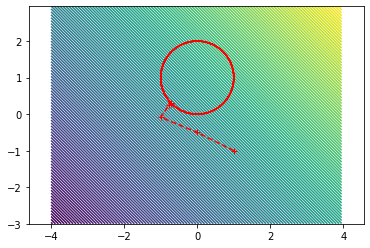

In [46]:
fig, ax = plt.subplots()
delta = 0.05
x0, x1 = np.meshgrid(np.arange(-4, 4, delta), np.arange(-3, 3, delta)) 
plot = np.zeros(x0.shape)
for i in range(x0.shape[0]):
    for j in range(x0.shape[1]):
        plot[i,j] = x0[i,j] + x1[i,j]
ax.contour(x0, x1,plot, 200)
x=np.linspace(-10,10,1000)
ax.plot(np.cos(x),np.sin(x)+1,'r')
ax.axis("equal")

x = np.array([1,-1])
l=1
eps=10**(-15)
Y,Lnorm=SQP(eps,f,f_grad,f_hess,eq,eq_jaco,eq_hess,x);
plt.plot(Y[:,0],Y[:,1],'r+', linestyle='dashed');

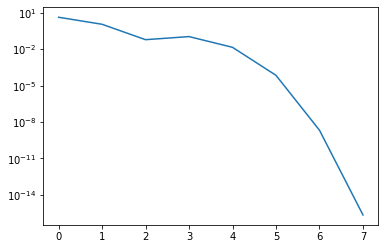

In [47]:
plt.semilogy(Lnorm);

#### Rosenbrock with quadratic equality constraints

Try the constraint Rosenbrock problem
$$
\left\{ \begin{array}{l}
\min (x_1-1)^2+100(x_1^2-x_2)^2
\\
x_1-x_2^2-\displaystyle\frac{1}{2} = 0.
\end{array} \right.
$$
Try with the initialization $\lambda_0 = 1$ and $X_0 = (-1,0)$, $(-1,1)$, $(1,1)$, $(1,-1)$.

In [35]:
def f2(x):
    return (x[0]-1)**2 + 100*(x[0]**2 - x[1])**2

def f_grad2(x):
    return np.array([2*(x[0]-1) + 400*x[0]*(x[0] - x[1]),-200*(x[0]**2 - x[1])])

def f_hess2(x):
    dxx = 2 + 400*(x[0]**2-x[1]) + 800*x[0]**2
    dxy = -400*x[0]
    dyy = 200
    return -np.array([[dxx,dxy],[dxy,dyy]])

def eq2(x):
    return x[0] - x[1]**2 - 1/2

def eq_jaco2(x):
    return -np.array([[1,-2*x[1]]])

def eq_hess2(x):
    return np.array([[0,0],[0,-2]])

M = [[-4.87210719e-04  2.43605359e-04 -1.22046285e-01]
 [ 2.43605359e-04 -1.21802680e-04 -4.38976857e-01]
 [-1.22046285e-01 -4.38976857e-01  1.99274056e+01]]
M = [[-2.56505598e-04  1.25232574e-04 -7.90332247e-02]
 [ 1.25232574e-04 -6.11417360e-05 -4.49639464e-01]
 [-7.90332247e-02 -4.49639464e-01 -1.85912141e+01]]
M = [[-1.62961339e-04  6.43948895e-05 -4.84646078e-02]
 [ 6.43948895e-05 -2.54459236e-05 -3.76003393e-01]
 [-4.84646078e-02 -3.76003393e-01 -3.99139573e+01]]
M = [[-1.10021148e-04  3.80605895e-05 -3.42995252e-02]
 [ 3.80605895e-05 -1.31666366e-05 -3.34073313e-01]
 [-3.42995252e-02 -3.34073313e-01 -5.27112178e+01]]
M = [[-7.90169151e-05  2.45178096e-05 -2.56698464e-02]
 [ 2.45178096e-05 -7.60752289e-06 -3.02320601e-01]
 [-2.56698464e-02 -3.02320601e-01 -6.43916467e+01]]
M = [[-5.94656891e-05  1.68855706e-05 -2.01638566e-02]
 [ 1.68855706e-05 -4.79473961e-06 -2.78229222e-01]
 [-2.01638566e-02 -2.78229222e-01 -7.41769710e+01]]
M = [[-4.64126109e-05  1.22285107e-05 -1.63958853e-0

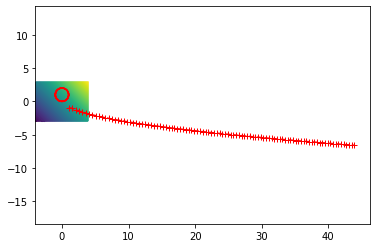

In [36]:
fig, ax = plt.subplots()
delta = 0.05
x0, x1 = np.meshgrid(np.arange(-4, 4, delta), np.arange(-3, 3, delta)) 
plot = np.zeros(x0.shape)
for i in range(x0.shape[0]):
    for j in range(x0.shape[1]):
        plot[i,j] = x0[i,j] + x1[i,j]
ax.contour(x0, x1,plot, 200)
x=np.linspace(-10,10,1000)
ax.plot(np.cos(x),np.sin(x)+1,'r')
ax.axis("equal")

x = np.array([1,-1])
l=1
eps=10**(-15)
Y,Lnorm=SQP(eps,f2,f_grad2,f_hess2,eq2,eq_jaco2,eq_hess2,x);
plt.plot(Y[:,0],Y[:,1],'r+', linestyle='dashed');

Text(0.5, 1.0, 'Lagrangian gradient norm')

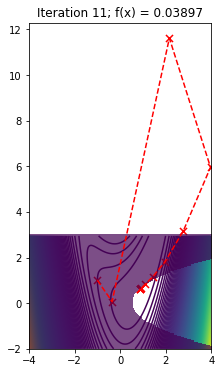

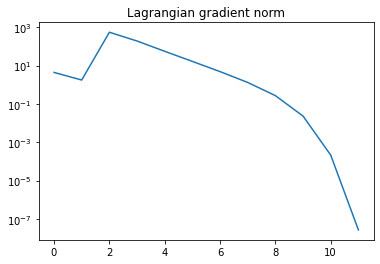